# **Topic : Topic Modelling in 2D space using Latent Semantic Analysis (LSA)**

## Team Members : 
19010 - Bhuvanashree Murugadoss <br />
19027 - Karna Sai Nikhilesh Reddy <br />
19030 - Kode Jai Surya <br />

## Analysis of Different sub-domains of input similar categories

### Input :  List of Documents/Titles

### Output: 2-D Plot of the Documents/Titles according to the topics/concepts

# Code:

## Importing the necessary modules

In [1]:
from scipy.linalg import svd
from math import log
from numpy import zeros,asarray,sum,array
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from adjustText import adjust_text
from IPython.display import display, HTML

## LSA Class : Which handles parsing, building, calculating SVD and TFIDF

In [2]:
class LSA(object):
    def __init__(self,stopwords,ignorechars):
        '''
        Function
        self.stopwords   : contains list of stopwords (changes with dataset)
        self.ignorechars : contains list of ignorechars (changes with dataset)
        self.wdict       : contains list of valid words
        self.dcount      : just a simple document counter
        '''
        self.stopwords = stopwords     
        self.ignorechars = ignorechars
        self.wdict = {}
        self.dcount = 0
        
    def translateWord(self,word):
        '''
        This function removes self.ignorechars from the input "word"
        '''
        return(''.join([ ch for ch in word if ch not in self.ignorechars]))
    
    def parse(self, doc):
        '''
        doc is a line/document from the dataset. It should be only String.
        '''
        doc_words = doc.split(" ")
        for word in doc_words:
            modified_word = self.translateWord(word.lower()).strip()
            if modified_word in self.stopwords:
                continue
            elif modified_word in self.wdict.keys():
                self.wdict[modified_word].append(self.dcount)
            else:
                self.wdict[modified_word] = [self.dcount]
        self.dcount += 1
    
    def build(self):
        '''
        self.keys         : holds keys list where each key repeat more than 1 time. 
        self.countmatrix  : hold the count matrix (row = key and column = doc index)
        '''
        self.keys = [key for (key,values) in self.wdict.items() if len(values) > 1]
        self.keys.sort()
        self.countmatrix = zeros([len(self.keys),self.dcount])
        for (index,key) in enumerate(self.keys):
            for doc_index in self.wdict[key]:
                self.countmatrix[index,doc_index] += 1
    
    def printcountmatrix(self):
        '''
        prints self.countmatrix that's all. Nothing more
        '''
        print(self.countmatrix)
        
    def calcTFIDF(self):
        '''
        It calculates TFIDF of countmatrix and stores the output in self.TFIDF
        
        (self.TFIDF_U, self.TFIDF_S, self.TFIDF_Vt) are used to store calculated SVD (U,S,Vt) from self.TFIDF
        '''
        col_sum = sum(self.countmatrix, axis=0)
        row_sum = sum(asarray(self.countmatrix>0), axis=1)
        rows , cols = self.countmatrix.shape
        self.TFIDF = zeros((rows,cols))
        for row_index in range(rows):
            for col_index in range(cols):
                self.TFIDF[row_index,col_index] = (self.countmatrix[row_index,col_index] * col_sum[col_index]) / (log(float(cols)) * row_sum[row_index])
        (self.TFIDF_U,self.TFIDF_S,self.TFIDF_Vt) = svd(self.TFIDF)
                
    def calcSVD(self):
        '''
        Calculates SVD of original Matrix (self.countmatrix) in (self.U, self.S, self.Vt)
        '''
        (self.U, self.S, self.Vt) = svd(self.countmatrix)
    
    def printSVD(self):
        '''
        Print's top important rows/columns from the SVD's U,S,Vt matrix.
        '''
        print('Singular Values:')
        print(self.S)
        print('U matrix for three cols :')
        print(-1* self.U[:,0:3])
        print('Vt matrix for three rows:')
        print(-1* self.U[0:3,:])
    
    def automatetheprocess(stopwords,ignorechars): 
        '''
        This function is used to automate the process of calling different functions in order.
        '''
        mylsa = LSA(stopwords,ignorechars)
        for title in titles:
            mylsa.parse(title)
        mylsa.build()
        mylsa.calcTFIDF()
        myTFIDF = mylsa.TFIDF
        mylsa.calcSVD()
        return mylsa

In [3]:
def describe_data(titles,stopwords,ignorechars):
    '''
    Description of the Input data.
    '''
    print("Data from Online:-")
    print(*["["+str(index)+"] "+data for index,data in enumerate(titles,1)], sep="\n")
    print()
    print('stopwords :',stopwords)
    print()
    print('ignorechars :', ignorechars)
    print()

def plot_sigmamatrix(mylsa):
    fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(20,5),dpi=80)

    countmatrix = array(mylsa.S)
    TFIDF_countmatrix = array(mylsa.TFIDF_S)
    count = array(range(1,len(countmatrix)+1))
    
    # ploting original countmatrix
    axes.plot(count,countmatrix,color='blue', marker='o', linestyle='--',linewidth=2, markersize=7,label='Original Singular Values')
    # ploting TFIDF countmatrix
    axes.plot(count,TFIDF_countmatrix,color='green', marker='o', linestyle='--',linewidth=2, markersize=7,label='TFIDF Singular Values')
    
    axes.set_xticks(count)
    axes.set_xlabel('Concepts')
    axes.set_ylabel('Singular Values From Matrix')
    axes.set_title('Comparison between Original and TFIDF Singular Values')
    axes.legend()
    axes.grid()

    plt.show()
    
def plot_heatmap(mylsa):
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(17,5),dpi=80)
    sns.despine(left=True)

    dim_count = 9
    df = pd.DataFrame(data = array(-1*mylsa.Vt[0:dim_count,:]),index=['Con['+str(index)+']' for index in range(1,dim_count+1)],columns = ['Doc['+str(index)+']' for index in range(1,mylsa.dcount+1)])
    sns.heatmap(df,cmap='RdBu',ax=axes[0])
    axes[0].set_xlabel("Titles")
    axes[0].set_ylabel("Concept")
    axes[0].set_title("Heatmap of Concepts and documents/titles of Original Vt Matrix")

    df = pd.DataFrame(data = array(-1*mylsa.TFIDF_Vt[0:dim_count,:]),index=['Con['+str(index)+']' for index in range(1,dim_count+1)],columns = ['Doc['+str(index)+']' for index in range(1,mylsa.dcount+1)])
    sns.heatmap(df,cmap='RdBu',ax=axes[1])
    axes[1].set_xlabel("Titles")
    axes[1].set_ylabel("Concept")
    axes[1].set_title("Heatmap of Concepts and documents/titles of TFIDF Vt Matrix")

    plt.tight_layout()
    plt.show()
    
def analyse_heatmap(mylsa,N):
    '''
    Analyse and create the clusters of titles(list) based on the topics
    '''
    first_dim , second_dim = -1*mylsa.TFIDF_Vt[N[0],:] , -1*mylsa.TFIDF_Vt[N[1],:]
    
    # segregated output based on their dimensions from Vt matrix
    heatmap = { 
        'Cluster 1 : Positive Positive Region' : [],
        'Cluster 2 : Positive Negative Region' : [],
        'Cluster 3 : Negative Negative Region' : [],
        'Cluster 4 : Negative Positive Region' : []
    }

    for (index,(d1,d2)) in enumerate(zip(first_dim,second_dim),1):
        if (d1>0 and d2>0):
            heatmap['Cluster 1 : Positive Positive Region'].append(index)
        elif (d1>0 and d2<0):
            heatmap['Cluster 2 : Positive Negative Region'].append(index)
        elif (d1<0 and d2<0):
            heatmap['Cluster 3 : Negative Negative Region'].append(index)
        elif (d1<0 and d2>0):
            heatmap['Cluster 4 : Negative Positive Region'].append(index)
            
    rep_plot_data = [["T"+str(index),'Title',dim1,dim2] for (index,(dim1,dim2)) in enumerate(zip(first_dim,second_dim),1)]
    
    for (key,(dim1,dim2)) in zip(mylsa.keys,zip(-1*mylsa.TFIDF_U[:,N[0]] , -1*mylsa.TFIDF_U[:,N[1]])):
        rep_plot_data.append([key,'Word',dim1,dim2])

    return(heatmap,rep_plot_data)
    
def plot_scatter_data(mylsa,plot_data,N,showclusters):
    '''
    plots a circular region about the data points - words and titles
    '''
    fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(10,7),dpi=80)
    adjusttext_keys = []
    
    for (key,typ,dim1,dim2) in plot_data:
        if typ == 'Title':
            if showclusters:
                axes.scatter(dim1,dim2,s = 7000 ,c='yellow',marker ="o",linewidths=2)
            ax_title = axes.scatter(dim1,dim2,c='blue',marker ="o")
        else:
            ax_label = axes.scatter(dim1,dim2,c='red',marker ="s")
        adjusttext_keys.append(axes.text(dim1,dim2,key))

    adjust_text(adjusttext_keys, arrowprops=dict(arrowstyle="-", color='r', lw=0.5))

    axes.set_xlabel('Dimension '+str(N[0]+1))
    axes.set_ylabel('Dimension '+str(N[1]+1))
    axes.set_title('XY Plot of Words and Titles');
    plt.legend((ax_title,ax_label),('Documents','Index Words'))
    plt.show()
    
def show_analysis(mylsa,titles,stopwords,ignorechars,showclusters=True,showgraphs=[1,1,1],N = [2,3],showmatrix=True):
    '''
    prints the original matrix and the TF-IDF matrix along with their corresponding SVD matrices 
    '''
    N = [N[0]-1,N[1]-1]
    
    if showmatrix:
        
        describe_data(titles,stopwords,ignorechars)
        
        print('Original Count matrix :')
        countmatrix_df = pd.DataFrame(data=mylsa.countmatrix, index=mylsa.keys, columns=['Document['+str(index)+']' for index in range(1,mylsa.countmatrix.shape[1]+1)])
        display(HTML(countmatrix_df.to_html()))
        print()

        print('TFIDF Count Matrix :')
        TFIDF_df = pd.DataFrame(data=mylsa.TFIDF, index=mylsa.keys, columns=['Document['+str(index)+']' for index in range(1,mylsa.countmatrix.shape[1]+1)])
        display(HTML(TFIDF_df.to_html()))
        print()

        print('Matrix of Original Singular Values :')
        countmatrix_S_df       = pd.DataFrame(data=np.diagflat(mylsa.S), index=['Concept ['+str(index)+']' for index in range(1,mylsa.S.shape[0]+1)] ,columns=['Concept ['+str(index)+']' for index in range(1,mylsa.S.shape[0]+1)])
        display(HTML(countmatrix_S_df .to_html()))
        print()

        print('Matrix of TFIDF Singular Values :')
        TFIDF_S_df       = pd.DataFrame(data=np.diagflat(mylsa.TFIDF_S), index=['Concept ['+str(index)+']' for index in range(1,mylsa.S.shape[0]+1)] ,columns=['Concept ['+str(index)+']' for index in range(1,mylsa.TFIDF_S.shape[0]+1)])
        display(HTML(TFIDF_S_df .to_html()))
        print()
    
    if showgraphs[0] == 1:
        plot_sigmamatrix(mylsa)
        print()
    
    if showmatrix:
        print('Original Vt Matrix :')
        countmatrix_Vt_df       = pd.DataFrame(data=mylsa.Vt, index=['Concept ['+str(index)+']' for index in range(1,mylsa.TFIDF_Vt.shape[1]+1)],columns=['Document ['+str(index)+']' for index in range(1,mylsa.Vt.shape[1]+1)])
        display(HTML(countmatrix_Vt_df .to_html()))
        print()

        print('TFIDF Vt Matrix :')
        TFIDF_Vt_df = pd.DataFrame(data=mylsa.TFIDF_Vt, index=['Concept ['+str(index)+']' for index in range(1,mylsa.TFIDF_Vt.shape[1]+1)], columns=['Document['+str(index)+']' for index in range(1,mylsa.TFIDF_Vt.shape[1]+1)])
        display(HTML(TFIDF_Vt_df .to_html()))
        print()
    
    if showgraphs[1] == 1:
        plot_heatmap(mylsa)
        print()
    
    heatmap_segments,plot_data = analyse_heatmap(mylsa,N)
    
    if (showclusters or showmatrix or showgraphs[2] == 1):
        print(f'HeatMap for Concept {N[0]+1} and Concept {N[1]+1} is analyzed into four categories :')
        print(*heatmap_segments.items(),sep='\n')
        print()
    
    if (showmatrix or (showgraphs[2] == 1)):
        print("Description of the points of Final Plot :")
        plot_data_df = pd.DataFrame(data=plot_data,index=range(1,len(plot_data)+1),columns=['Keys','Category','Dimension '+str(N[0]+1),'Dimension '+str(N[1]+1)]).T
        display(HTML(plot_data_df .to_html()))
        print()
    
    if showgraphs[2] == 1:
        plot_scatter_data(mylsa,plot_data,N,showclusters)

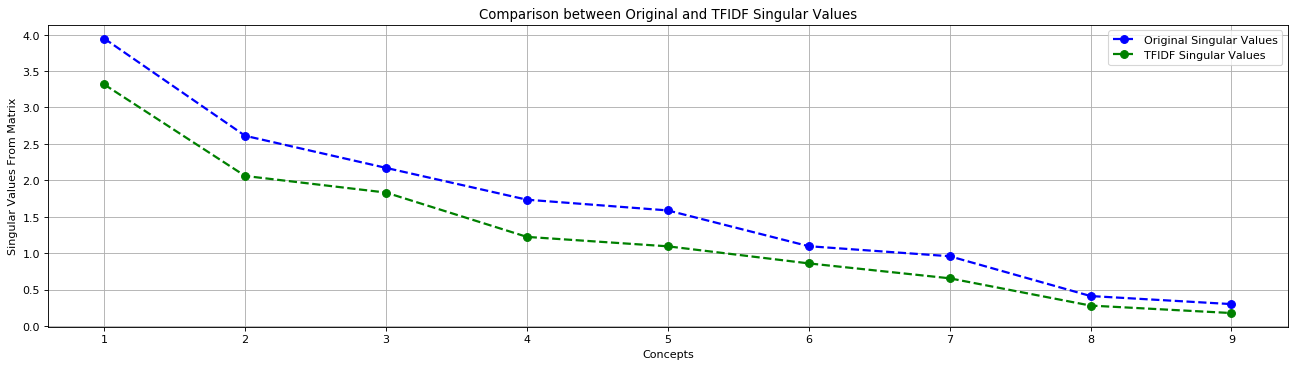

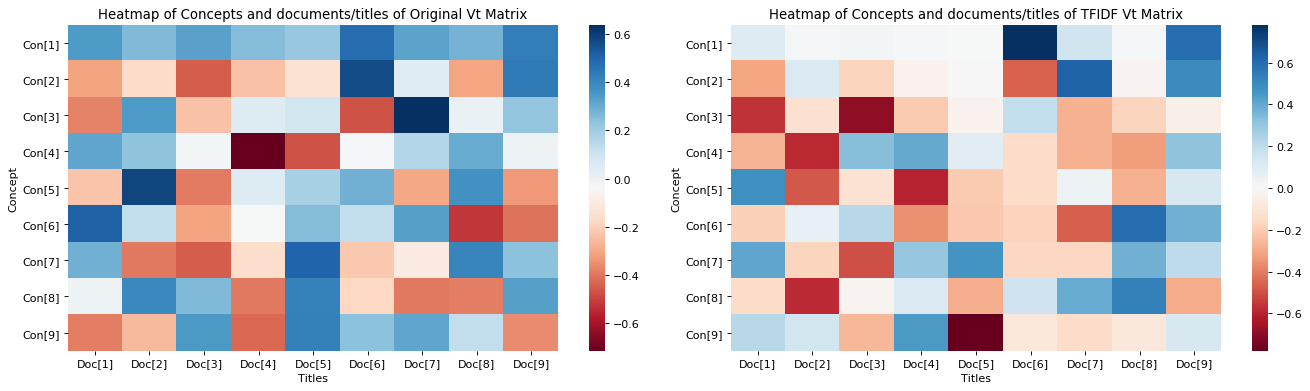


HeatMap for Concept 2 and Concept 3 is analyzed into four categories :
('Cluster 1 : Positive Positive Region', [])
('Cluster 2 : Positive Negative Region', [2, 7, 9])
('Cluster 3 : Negative Negative Region', [1, 3, 4, 5, 8])
('Cluster 4 : Negative Positive Region', [6])

Description of the points of Final Plot :


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
Keys,T1,T2,T3,T4,T5,T6,T7,T8,T9,book,dads,dummies,edition,estate,guide,investing,market,real,rich,stock,value
Category,Title,Title,Title,Title,Title,Title,Title,Title,Title,Word,Word,Word,Word,Word,Word,Word,Word,Word,Word,Word,Word
Dimension 2,-0.305691,0.118691,-0.171145,-0.0298776,-0.00101553,-0.461357,0.634076,-0.0192222,0.497,-0.0855418,0.0196911,0.0329707,0.319576,0.554799,-0.389976,0.024895,-0.21074,0.554799,-0.235183,-0.144741,-0.0101278
Dimension 3,-0.563898,-0.125984,-0.692371,-0.203728,-0.0314283,0.191044,-0.27665,-0.171243,-0.0438127,-0.420064,0.0914713,-0.110796,-0.184463,-0.16472,-0.161577,-0.192215,-0.62439,-0.16472,0.210162,-0.458816,-0.0837527


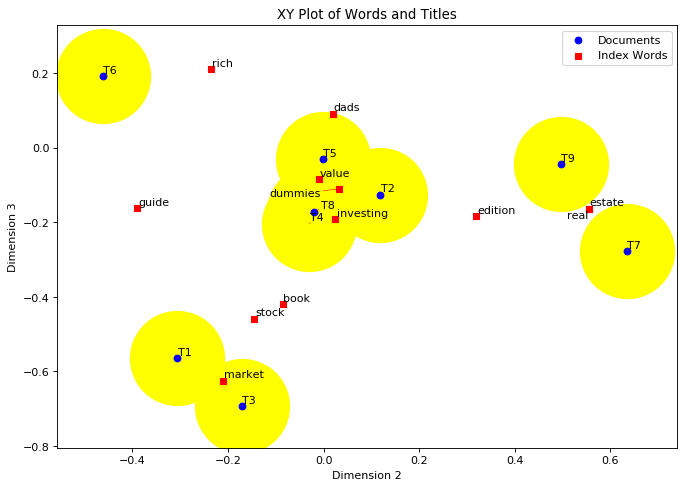

In [4]:
titles = [ 
"The Neatest Little Guide to Stock Market Investing", 
"Investing For Dummies, 4th Edition", 
"The Little Book of Common Sense Investing: The Only Way to Guarantee Your Fair Share of Stock Market Returns", 
"The Little Book of Value Investing", 
"Value Investing: From Graham to Buffett and Beyond", 
"Rich Dad's Guide to Investing: What the Rich Invest in, That the Poor and the Middle Class Do Not!", 
"Investing in Real Estate, 5th Edition", 
"Stock Investing For Dummies", 
"Rich Dad's Advisors: The ABC's of Real Estate Investing: The Secrets of Finding Hidden Profits Most Investors Miss" 
]

stopwords = ['and','a','for','in','little','of','the','to','from','','an','is','was','on','one','its','which','as']
ignorechars = ''',:'!'''

dataset_1 = LSA.automatetheprocess(stopwords,ignorechars)
show_analysis(dataset_1,titles,stopwords,ignorechars,showgraphs=[1,1,1],showclusters=True,N = [2,3],showmatrix=False) # showgraphs=[Sigmamatrix, Vtmatrix, Finalplot]

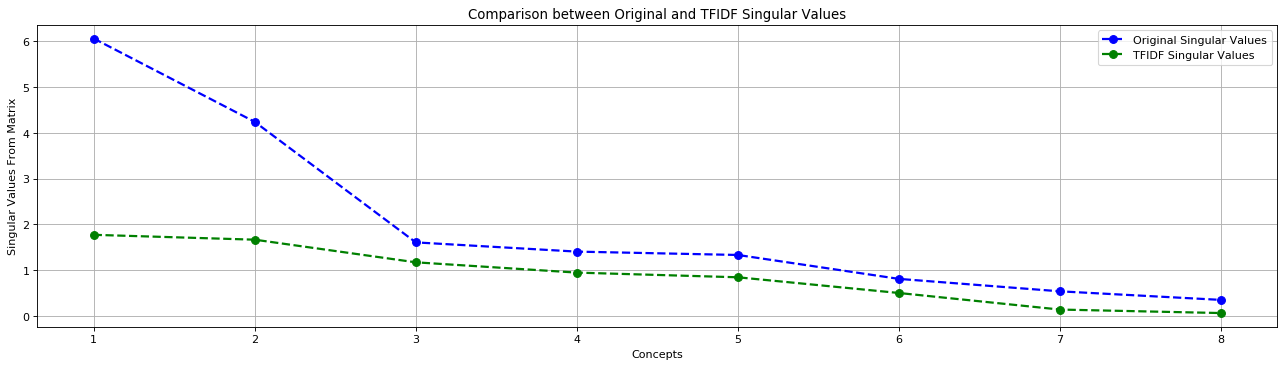

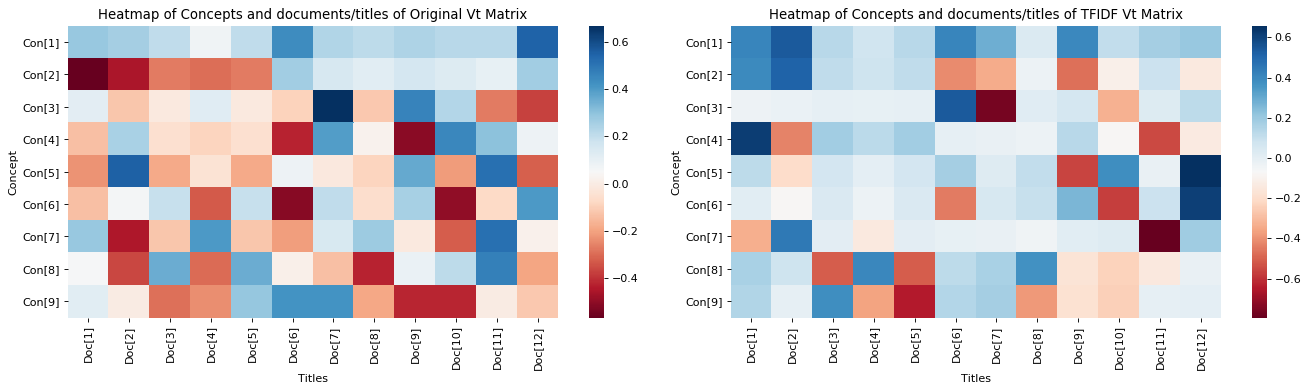


HeatMap for Concept 6 and Concept 7 is analyzed into four categories :
('Cluster 1 : Positive Positive Region', [3, 5, 9, 12])
('Cluster 2 : Positive Negative Region', [1, 7, 8, 11])
('Cluster 3 : Negative Negative Region', [4, 6])
('Cluster 4 : Negative Positive Region', [2, 10])

Description of the points of Final Plot :


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Keys,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,army,country,courage,cricket,forces,full,indian,team
Category,Title,Title,Title,Title,Title,Title,Title,Title,Title,Title,Title,Title,Word,Word,Word,Word,Word,Word,Word,Word
Dimension 6,0.0150181,-0.0776683,0.042903,-0.0225947,0.042903,-0.442001,0.0544292,0.0980995,0.261821,-0.567893,0.0895409,0.618489,0.204944,-0.465668,-0.595127,-0.0663664,0.506631,-0.0479472,0.351539,-0.00415425
Dimension 7,-0.328686,0.45171,0.0118029,-0.139343,0.0118029,-0.00816865,-0.0158784,-0.0353499,0.0143496,0.0254527,-0.793233,0.191279,-0.22387,0.0236258,0.0183304,0.583606,-0.00872671,-0.172894,0.283676,-0.705657


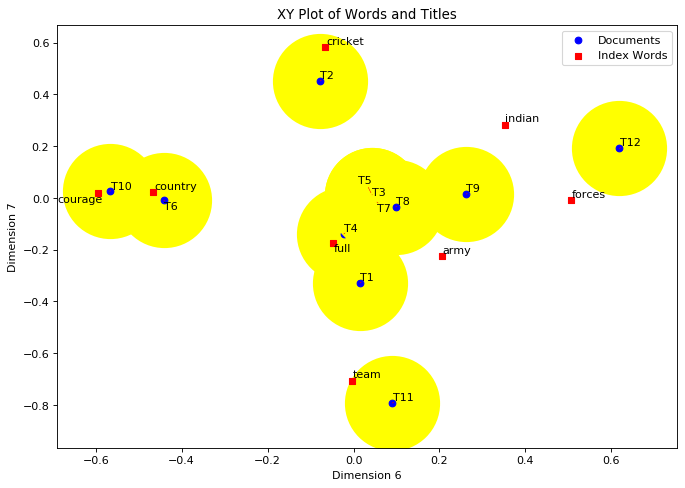

In [7]:
# This dataset contains 12 Doc's and they're about Indian cricket team (first 5 Doc's) and Indian Army (last 7 Doc's)
titles = [ 
"The Indian cricket team is the team that represents India in the cricket game.",
"The Indian cricket team is a full member of the International Cricket Council (ICC).",
"Indian cricket team plays all formats i.e. Tests, One Day and T20 internationals.",
"Virat Kohli is the captain and Rohit Sharma is the vice-captain of the cricket team.",
"On 25th June 1932, the Indian cricket team was granted the status of test playing nation.",
"indian army Indian Army is the real protector of this country.",
"Indian Army is one the defense forces which is respected and admired everywhere around the world for its courage and decency.",
"Indian Army is the helping hand of other agencies in various military operations.",
"Indian Army is committed to save the country from land based attacks by enemy forces.",
"Everybody knows Indian Army as another name of courage.",
"Indian Army has a long and glorious history which is full of victories over enemies.",
"being an indian cant stop saying about tye intelligence and inportance of our powerful indian army solute hole indian army."
]

stopwords = ['and','a','for','in','little','of','the','to','from','','an','is','was','on','one','its','which','as']
ignorechars = ''',:.'!'''

dataset_2 = LSA.automatetheprocess(stopwords,ignorechars)
show_analysis(dataset_2,titles,stopwords,ignorechars,showgraphs=[1,1,1],showclusters=True,N = [6,7],showmatrix=False) # showgraphs=[Sigmamatrix, Vtmatrix, Finalplot]